In [14]:
# Imports
import pickle
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
from matplotlib.patches import Patch
import pickle
import os
import time

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [16]:
# Define and populate the maze structure ma with size 6
ma=NewMaze(6)

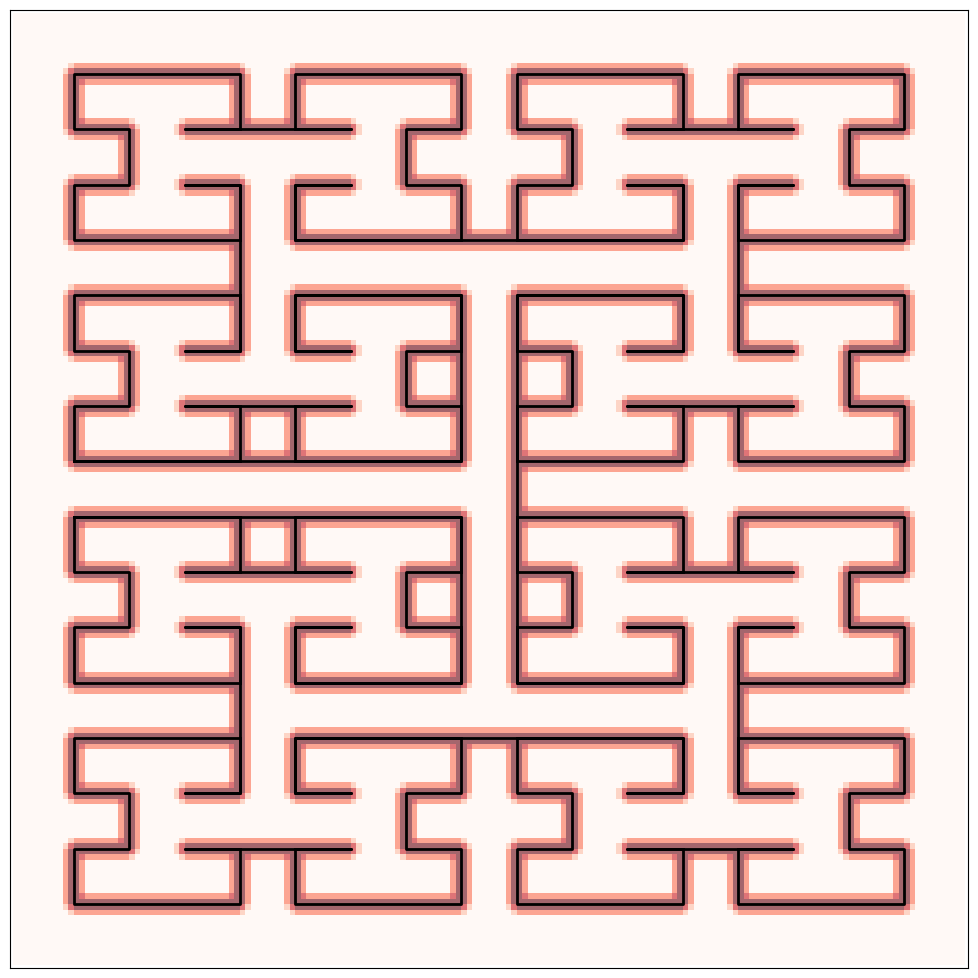

In [36]:
## Generate maze wall boundaries

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

def precompute_wall_zones_with_shift(ma, threshold=0.1, resolution=0.1, shift_x=0.5, shift_y=0.5):
   # Determine maze bounds
   x_min, x_max = np.min(ma.wa[:, 0]), np.max(ma.wa[:, 0])
   y_min, y_max = np.min(ma.wa[:, 1]), np.max(ma.wa[:, 1])
   
   # Add padding
   padding = threshold + 1
   x_min -= padding
   x_max += padding
   y_min -= padding
   y_max += padding
   
   # Create grid
   x_range = np.arange(x_min, x_max, resolution)
   y_range = np.arange(y_min, y_max, resolution)
   X, Y = np.meshgrid(x_range, y_range)
   
   # Initialize wall mask
   wall_mask = np.zeros_like(X, dtype=bool)
   
   # Draw walls on the mask
   for i in range(len(ma.wa) - 1):
       p1 = ma.wa[i]
       p2 = ma.wa[i+1]
       
       t = np.linspace(0, 1, max(2, int(np.sqrt(np.sum((p2-p1)**2)) / (resolution/2))))
       wall_x = p1[0] + t * (p2[0] - p1[0])
       wall_y = p1[1] + t * (p2[1] - p1[1])
       
       for wx, wy in zip(wall_x, wall_y):
           x_idx = np.argmin(np.abs(X[0, :] - wx))
           y_idx = np.argmin(np.abs(Y[:, 0] - wy))
           if 0 <= y_idx < wall_mask.shape[0] and 0 <= x_idx < wall_mask.shape[1]:
               wall_mask[y_idx, x_idx] = True
   
   # Compute distance transform
   dist = distance_transform_edt(~wall_mask) * resolution
   
   # Create wall zone mask
   is_wall_zone = dist <= threshold
   
   # Apply non-integer shift using interpolation
   y_indices = np.arange(is_wall_zone.shape[0])
   x_indices = np.arange(is_wall_zone.shape[1])
   y_coords = y_indices - shift_y/resolution
   x_coords = x_indices - shift_x/resolution
   
   # Create new coordinate grid
   yy, xx = np.meshgrid(y_coords, x_coords, indexing='ij')
   
   # Interpolate
   from scipy.interpolate import RegularGridInterpolator
   interp = RegularGridInterpolator((y_indices, x_indices), is_wall_zone, 
                                    bounds_error=False, fill_value=False)
   
   # Apply interpolation to get shifted mask
   points = np.vstack([yy.flatten(), xx.flatten()]).T
   is_wall_zone_shifted = interp(points).reshape(is_wall_zone.shape)
   
   # Visualize
   plt.figure(figsize=(10, 10))
   plt.imshow(is_wall_zone_shifted, extent=[x_min, x_max, y_max, y_min], cmap='Reds', alpha=0.6)
   plt.plot(ma.wa[:, 0], ma.wa[:, 1], 'k-', linewidth=2)
   plt.axis('equal')
   plt.xticks([])
   plt.yticks([])
   plt.tight_layout()
   plt.show()
   
   return X, Y, is_wall_zone_shifted

def is_near_wall_precomputed(x, y, X, Y, is_wall_zone):
   # Find indices
   x_idx = np.clip(np.searchsorted(X[0, :], x) - 1, 0, X.shape[1] - 2)
   y_idx = np.clip(np.searchsorted(Y[:, 0], y) - 1, 0, Y.shape[0] - 2)
   
   # Check nearby cells
   return (is_wall_zone[y_idx, x_idx] or is_wall_zone[y_idx, x_idx+1] or 
           is_wall_zone[y_idx+1, x_idx] or is_wall_zone[y_idx+1, x_idx+1])

# Generate and save
X, Y, is_wall_zone = precompute_wall_zones_with_shift(ma, threshold=0.1, resolution=0.1, shift_x=-0.05, shift_y=-0.05)
np.savez('wall_zones.npz', X=X, Y=Y, is_wall_zone=is_wall_zone)

Figure saved as mouse_B1_bout_17_final_maze_trajectory.pdf


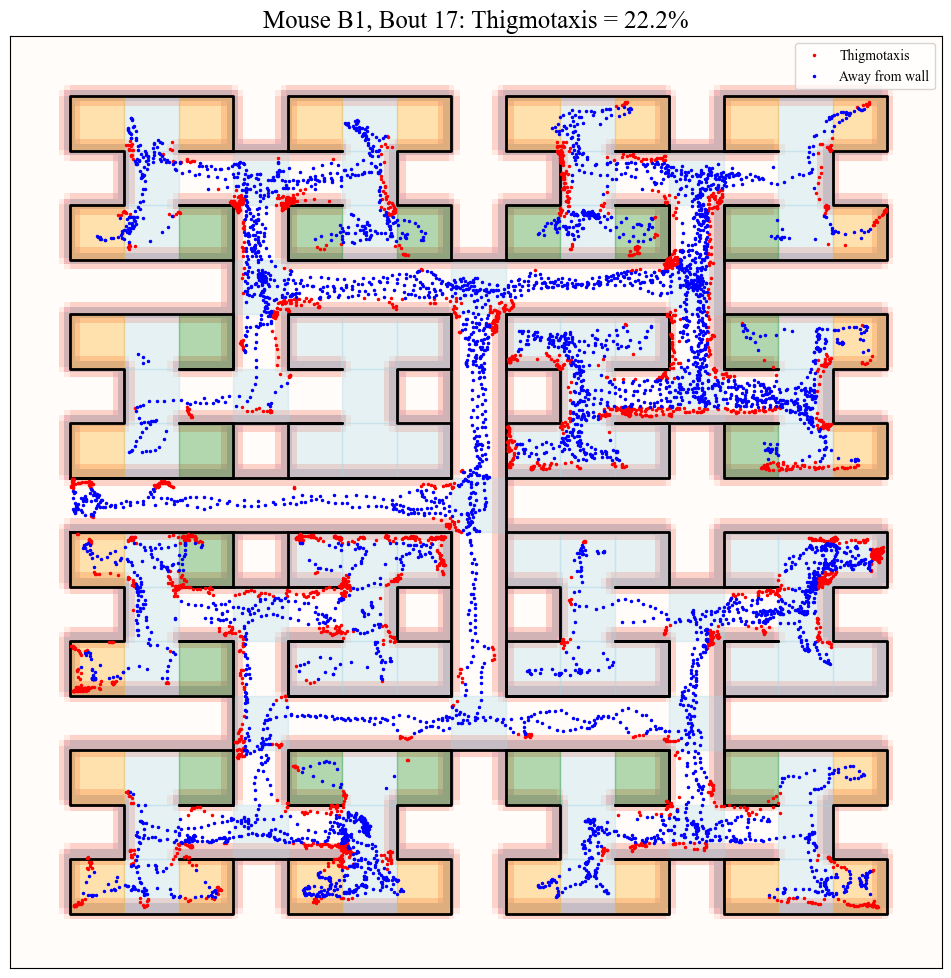

22.204824866620275

In [38]:
## Plots Single bout trajectory against maze with wall boundaries and thigmottaxis analysis 

import numpy as np
import matplotlib.patches as patches
from matplotlib.patches import Patch
import matplotlib as mpl

# Set Font sizes
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12

# Define inner and outer nodes
inner_nodes = [66, 72, 74, 96, 98, 104, 107, 108, 119, 120, 123, 93, 91, 85, 82, 81, 70, 69]
outer_nodes = [63, 65, 71, 73, 95, 97, 103, 105, 106, 109, 110, 121, 122, 125, 126, 124, 94, 92, 86, 84, 83, 80, 79, 68, 67, 64]


def visualize_all_nodes(ma, inner_nodes, outer_nodes, ax=None, inner_color='green', outer_color='orange', other_color='lightblue', box_size=1.0):
    """
    Draw boundary boxes around all nodes, color-coded by their category
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
        # Plot maze walls
        ax.plot(ma.wa[:, 0], ma.wa[:, 1], 'k-', linewidth=2)
    
    # Get all node coordinates
    node_coordinates = {}
    for j in range(len(ma.ru)):
        node_coordinates[j] = (ma.xc[ma.ru[j][-1]], ma.yc[ma.ru[j][-1]])
    
    # Legend elements
    legend_elements = []
    
    # First, draw boxes for nodes that are neither inner nor outer
    other_drawn = False
    for node, (x, y) in node_coordinates.items():
        if node not in inner_nodes and node not in outer_nodes:
            half_size = box_size / 2
            rect = patches.Rectangle((x - half_size, y - half_size), box_size, box_size, 
                                  linewidth=1, edgecolor=other_color, facecolor=other_color, alpha=0.3)
            ax.add_patch(rect)
            
            if not other_drawn:
                legend_elements.append(Patch(facecolor=other_color, alpha=0.3, label='Other Nodes'))
                other_drawn = True

    # Draw inner nodes
    inner_drawn = False
    for node in inner_nodes:
        x, y = node_coordinates[node]
        half_size = box_size / 2
        rect = patches.Rectangle((x - half_size, y - half_size), box_size, box_size, 
                              linewidth=1, edgecolor=inner_color, facecolor=inner_color, alpha=0.3)
        ax.add_patch(rect)
        
        if not inner_drawn:
            legend_elements.append(Patch(facecolor=inner_color, alpha=0.3, label='Inner Nodes'))
            inner_drawn = True

    # Draw outer nodes
    outer_drawn = False
    for node in outer_nodes:
        x, y = node_coordinates[node]
        half_size = box_size / 2
        rect = patches.Rectangle((x - half_size, y - half_size), box_size, box_size, 
                              linewidth=1, edgecolor=outer_color, facecolor=outer_color, alpha=0.3)
        ax.add_patch(rect)
        
        if not outer_drawn:
            legend_elements.append(Patch(facecolor=outer_color, alpha=0.3, label='Outer Nodes'))
            outer_drawn = True

    # Add legend
    ax.legend(handles=legend_elements)
    
    # Set proper scaling
    ax.set_aspect('equal')
    return ax

def visualize_trajectory_with_walls_and_nodes(mouse_id, bout_number, X, Y, is_wall_zone, inner_nodes, outer_nodes, save_pdf=True):
    # Load trajectory
    tf = LoadTraj(mouse_id+'-tf')
    
    # Extract trajectory data
    traj_x = -0.5 + 15 * tf.ke[bout_number][:,0]
    traj_y = -0.5 + 15 * tf.ke[bout_number][:,1]
    
    # Remove invalid points
    valid_indices = np.isfinite(traj_x) & np.isfinite(traj_y)
    traj_x = traj_x[valid_indices]
    traj_y = traj_y[valid_indices]
    
    # Check wall proximity
    wall_touches = [is_near_wall_precomputed(traj_x[i], traj_y[i], X, Y, is_wall_zone) 
                   for i in range(len(traj_x))]
    
    # Calculate thigmotaxis percentage
    thigmotaxis_percent = (sum(wall_touches) / len(wall_touches)) * 100
    
    # Separate trajectory points by wall proximity
    wall_indices = [i for i, is_near in enumerate(wall_touches) if is_near]
    non_wall_indices = [i for i, is_near in enumerate(wall_touches) if not is_near]
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show wall zones with proper extent
    x_min, x_max = X[0,0], X[0,-1]
    y_min, y_max = Y[-1,0], Y[0,0]
    im = ax.imshow(is_wall_zone, extent=[x_min, x_max, y_min, y_max], 
                  cmap='Reds', alpha=0.3, origin='upper')
    
    # Show maze walls
    ax.plot(ma.wa[:, 0], ma.wa[:, 1], 'k-', linewidth=2)  
    
    # Add nodes visualization
    visualize_all_nodes(ma, inner_nodes, outer_nodes, ax=ax, box_size=1.0)
    
    # Plot trajectory points
    if wall_indices:
        ax.plot(traj_x[wall_indices], traj_y[wall_indices], 'ro', markersize=1.5, label='Thigmotaxis')  
    if non_wall_indices:
        ax.plot(traj_x[non_wall_indices], traj_y[non_wall_indices], 'bo', markersize=1.5, label='Away from wall')  # Increased marker size

    
    # Remove grid numbers
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set title 
    ax.set_title(f"Mouse {mouse_id}, Bout {bout_number}: Thigmotaxis = {thigmotaxis_percent:.1f}%", fontsize=18)
    
    # Adjust legend
    ax.legend(fontsize=10)
    
    # Tight layout
    plt.tight_layout()
    
    # Save as PDF
    if save_pdf:
        pdf_filename = f"mouse_{mouse_id}_bout_{bout_number}_final_maze_trajectory.pdf"
        plt.savefig(pdf_filename, bbox_inches='tight', format='pdf')
        print(f"Figure saved as {pdf_filename}")
    
    plt.show()
    
    return thigmotaxis_percent


# Example bout for visualisation
test_mouse_id = 'B1'
boutID = 17

visualize_trajectory_with_walls_and_nodes(test_mouse_id, boutID, X, Y, is_wall_zone, inner_nodes, outer_nodes, save_pdf=True)

In [42]:
## Core thigmotaxis calculations for all mice WARNING: WILL TAKE ABOUT 20 mins!

def analyze_node_thigmotaxis(mouse_id, bout_number, X, Y, is_wall_zone, inner_nodes, outer_nodes, node_threshold=0.5):
    """
    Analyze what percentage of trajectory points in each node category (inner, outer, other)
    are touching walls.
    """
    # Load trajectory
    tf = LoadTraj(mouse_id+'-tf')
    
    # Extract trajectory data
    traj_x = -0.5 + 15 * tf.ke[bout_number][:,0]
    traj_y = -0.5 + 15 * tf.ke[bout_number][:,1]
    
    # Remove invalid points
    valid_indices = np.isfinite(traj_x) & np.isfinite(traj_y)
    traj_x = traj_x[valid_indices]
    traj_y = traj_y[valid_indices]
    
    # Check wall proximity for all points
    wall_touches = [is_near_wall_precomputed(traj_x[i], traj_y[i], X, Y, is_wall_zone) 
                   for i in range(len(traj_x))]
    
    # Initialize counters
    inner_points = 0
    outer_points = 0
    other_points = 0
    inner_wall = 0
    outer_wall = 0
    other_wall = 0
    
    # Get all node coordinates
    node_coordinates = {}
    for j in range(len(ma.ru)):
        node_coordinates[j] = (ma.xc[ma.ru[j][-1]], ma.yc[ma.ru[j][-1]])
    
    # Iterate through trajectory points
    for i in range(len(traj_x)):
        x, y = traj_x[i], traj_y[i]
        near_wall = wall_touches[i]
        
        # Find which node this point is closest to (if any)
        min_dist = float('inf')
        closest_node = None
        
        for node, (node_x, node_y) in node_coordinates.items():
            dist = np.sqrt((x - node_x)**2 + (y - node_y)**2)
            if dist < min_dist:
                min_dist = dist
                closest_node = node
        
        # If point is within threshold of a node, count it
        if min_dist <= node_threshold and closest_node is not None:
            if closest_node in inner_nodes:
                inner_points += 1
                if near_wall:
                    inner_wall += 1
            elif closest_node in outer_nodes:
                outer_points += 1
                if near_wall:
                    outer_wall += 1
            else:
                other_points += 1
                if near_wall:
                    other_wall += 1
    
    # Calculate percentages (handle zero division)
    inner_thigmo_pct = (inner_wall / inner_points * 100) if inner_points > 0 else 0
    outer_thigmo_pct = (outer_wall / outer_points * 100) if outer_points > 0 else 0
    other_thigmo_pct = (other_wall / other_points * 100) if other_points > 0 else 0
    
    # Calculate outer:inner ratio (handle zero division)
    if inner_points > 0:
        outer_inner_ratio = outer_points / inner_points
    else:
        outer_inner_ratio = None  # Use None instead of infinity
    
    # Calculate thigmotaxis ratio (handle zero division)
    if inner_thigmo_pct > 0:
        thigmotaxis_ratio = outer_thigmo_pct / inner_thigmo_pct
    else:
        thigmotaxis_ratio = None  # Use None instead of infinity
    
    # Print summary (handling None values)
    print(f"Mouse {mouse_id}, Bout {bout_number}:")
    print(f"Inner nodes: {inner_points} points, {inner_wall} wall touches ({inner_thigmo_pct:.1f}%)")
    print(f"Outer nodes: {outer_points} points, {outer_wall} wall touches ({outer_thigmo_pct:.1f}%)")
    print(f"Other nodes: {other_points} points, {other_wall} wall touches ({other_thigmo_pct:.1f}%)")
    
    if outer_inner_ratio is not None:
        print(f"Outer:Inner ratio = {outer_inner_ratio:.2f}")
    else:
        print("Outer:Inner ratio = N/A (no inner node visits)")
    
    if thigmotaxis_ratio is not None:
        print(f"Thigmotaxis ratio (outer:inner) = {thigmotaxis_ratio:.2f}")
    else:
        print("Thigmotaxis ratio = N/A (no inner node wall touches)")
    
    # Create results dictionary
    results = {
        'mouse_id': mouse_id,
        'bout_number': bout_number,
        'inner_points': inner_points,
        'inner_wall': inner_wall,
        'inner_thigmo_pct': inner_thigmo_pct,
        'outer_points': outer_points,
        'outer_wall': outer_wall,
        'outer_thigmo_pct': outer_thigmo_pct,
        'other_points': other_points,
        'other_wall': other_wall,
        'other_thigmo_pct': other_thigmo_pct,
        'outer_inner_ratio': outer_inner_ratio,
        'thigmotaxis_ratio': thigmotaxis_ratio
    }
    
    return results

def analyze_mouse_thigmotaxis(mouse_id, X, Y, is_wall_zone, inner_nodes, outer_nodes, sample_percentage=100):
    """
    Analyze thigmotaxis for a percentage of bouts for a single mouse
    
    Parameters:
    mouse_id - ID of the mouse to analyze
    X, Y, is_wall_zone - Precomputed wall zones
    inner_nodes, outer_nodes - Lists of node categories
    sample_percentage - Percentage of bouts to analyze (e.g., 50 means analyze half the bouts)
    """
    # Load trajectory
    tf = LoadTraj(mouse_id+'-tf')
    total_bouts = len(tf.ke)
    
    # Determine which bouts to analyze
    num_bouts_to_analyze = int(total_bouts * sample_percentage / 100)
    # Take evenly spaced bouts to get a representative sample
    bout_indices = np.linspace(0, total_bouts-1, num_bouts_to_analyze, dtype=int)
    
    print(f"Analyzing {num_bouts_to_analyze} bouts out of {total_bouts} total for mouse {mouse_id}")
    
    # Store results for all analyzed bouts
    all_bout_results = []
    
    # Track totals across all bouts
    mouse_totals = {
        'inner_points': 0,
        'inner_wall': 0,
        'outer_points': 0,
        'outer_wall': 0,
        'other_points': 0,
        'other_wall': 0
    }
    
    # Process each selected bout
    for i, bout in enumerate(bout_indices):
        try:
            print(f"Processing bout {bout} ({i+1}/{len(bout_indices)})")
            bout_results = analyze_node_thigmotaxis(mouse_id, bout, X, Y, is_wall_zone, inner_nodes, outer_nodes)
            
            # Add to mouse totals
            for key in mouse_totals:
                mouse_totals[key] += bout_results[key]
            
            all_bout_results.append(bout_results)
        except Exception as e:
            print(f"Error processing bout {bout}: {str(e)}")
    
    # Calculate overall mouse statistics
    inner_thigmo_pct = (mouse_totals['inner_wall'] / mouse_totals['inner_points'] * 100) if mouse_totals['inner_points'] > 0 else 0
    outer_thigmo_pct = (mouse_totals['outer_wall'] / mouse_totals['outer_points'] * 100) if mouse_totals['outer_points'] > 0 else 0
    other_thigmo_pct = (mouse_totals['other_wall'] / mouse_totals['other_points'] * 100) if mouse_totals['other_points'] > 0 else 0
    
    outer_inner_ratio = mouse_totals['outer_points'] / mouse_totals['inner_points'] if mouse_totals['inner_points'] > 0 else None
    thigmotaxis_ratio = outer_thigmo_pct / inner_thigmo_pct if inner_thigmo_pct > 0 else None
    
    # Create summary results
    mouse_summary = {
        'mouse_id': mouse_id,
        'num_bouts_analyzed': len(all_bout_results),
        'inner_points': mouse_totals['inner_points'],
        'inner_wall': mouse_totals['inner_wall'],
        'inner_thigmo_pct': inner_thigmo_pct,
        'outer_points': mouse_totals['outer_points'],
        'outer_wall': mouse_totals['outer_wall'],
        'outer_thigmo_pct': outer_thigmo_pct,
        'other_points': mouse_totals['other_points'],
        'other_wall': mouse_totals['other_wall'],
        'other_thigmo_pct': other_thigmo_pct,
        'outer_inner_ratio': outer_inner_ratio,
        'thigmotaxis_ratio': thigmotaxis_ratio,
        'bout_results': all_bout_results
    }
    
    # Print summary
    print(f"\nSummary for mouse {mouse_id}:")
    print(f"Analyzed {len(all_bout_results)} bouts")
    print(f"Inner nodes: {mouse_totals['inner_points']} points, {mouse_totals['inner_wall']} wall touches ({inner_thigmo_pct:.1f}%)")
    print(f"Outer nodes: {mouse_totals['outer_points']} points, {mouse_totals['outer_wall']} wall touches ({outer_thigmo_pct:.1f}%)")
    print(f"Other nodes: {mouse_totals['other_points']} points, {mouse_totals['other_wall']} wall touches ({other_thigmo_pct:.1f}%)")
    
    if outer_inner_ratio is not None:
        print(f"Outer:Inner ratio = {outer_inner_ratio:.2f}")
    else:
        print("Outer:Inner ratio = N/A (no inner node visits)")
    
    if thigmotaxis_ratio is not None:
        print(f"Thigmotaxis ratio (outer:inner) = {thigmotaxis_ratio:.2f}")
    else:
        print("Thigmotaxis ratio = N/A (no inner node wall touches)")
    
    # Save results to pickle
    os.makedirs('mouse_results', exist_ok=True)
    with open(f'mouse_results/{mouse_id}_thigmotaxis.pkl', 'wb') as f:
        pickle.dump(mouse_summary, f)
    
    print(f"Results saved to mouse_results/{mouse_id}_thigmotaxis.pkl")
    
    return mouse_summary

def analyze_all_mice(X, Y, is_wall_zone, inner_nodes, outer_nodes, sample_percentage=100):
    """
    Analyze thigmotaxis for all mice, both rewarded and unrewarded
    """
    # Define mice lists
    RewNames = ['B1', 'B2', 'B3', 'B4', 'C1', 'C3', 'C6', 'C7', 'C8', 'C9']
    # Exclude D6 which barely entered the maze
    UnrewNamesSub = ['B5', 'B6', 'B7', 'D3', 'D4', 'D5', 'D7', 'D8', 'D9']
    
    # Store all mice summaries
    all_mice_summaries = []
    
    # Process rewarded mice
    print("Processing rewarded mice...")
    for mouse_id in RewNames:
        try:
            print(f"\n==== Processing rewarded mouse: {mouse_id} ====")
            mouse_summary = analyze_mouse_thigmotaxis(mouse_id, X, Y, is_wall_zone, 
                                                     inner_nodes, outer_nodes, 
                                                     sample_percentage)
            mouse_summary['rewarded'] = True
            all_mice_summaries.append(mouse_summary)
        except Exception as e:
            print(f"Error processing mouse {mouse_id}: {str(e)}")
    
    # Process unrewarded mice
    print("\nProcessing unrewarded mice...")
    for mouse_id in UnrewNamesSub:
        try:
            print(f"\n==== Processing unrewarded mouse: {mouse_id} ====")
            mouse_summary = analyze_mouse_thigmotaxis(mouse_id, X, Y, is_wall_zone, 
                                                     inner_nodes, outer_nodes, 
                                                     sample_percentage)
            mouse_summary['rewarded'] = False
            all_mice_summaries.append(mouse_summary)
        except Exception as e:
            print(f"Error processing mouse {mouse_id}: {str(e)}")
    
    # Save combined results
    with open('all_mice_thigmotaxis.pkl', 'wb') as f:
        pickle.dump(all_mice_summaries, f)
    
    print("\nAll mice processed. Combined results saved to all_mice_thigmotaxis.pkl")
    
    # Calculate population statistics
    rew_summaries = [m for m in all_mice_summaries if m['rewarded']]
    unrew_summaries = [m for m in all_mice_summaries if not m['rewarded']]
    
    print("\nPopulation Statistics:")
    print(f"Rewarded mice (n={len(rew_summaries)}):")
    if rew_summaries:
        valid_ratios = [m['outer_inner_ratio'] for m in rew_summaries if m['outer_inner_ratio'] is not None]
        valid_thigmo = [m['thigmotaxis_ratio'] for m in rew_summaries if m['thigmotaxis_ratio'] is not None]
        
        if valid_ratios:
            avg_outer_inner = np.mean(valid_ratios)
            print(f"  Average outer:inner ratio: {avg_outer_inner:.2f}")
        else:
            print("  Average outer:inner ratio: N/A")
            
        if valid_thigmo:
            avg_thigmo_ratio = np.mean(valid_thigmo)
            print(f"  Average thigmotaxis ratio: {avg_thigmo_ratio:.2f}")
        else:
            print("  Average thigmotaxis ratio: N/A")
    
    print(f"Unrewarded mice (n={len(unrew_summaries)}):")
    if unrew_summaries:
        valid_ratios = [m['outer_inner_ratio'] for m in unrew_summaries if m['outer_inner_ratio'] is not None]
        valid_thigmo = [m['thigmotaxis_ratio'] for m in unrew_summaries if m['thigmotaxis_ratio'] is not None]
        
        if valid_ratios:
            avg_outer_inner = np.mean(valid_ratios)
            print(f"  Average outer:inner ratio: {avg_outer_inner:.2f}")
        else:
            print("  Average outer:inner ratio: N/A")
            
        if valid_thigmo:
            avg_thigmo_ratio = np.mean(valid_thigmo)
            print(f"  Average thigmotaxis ratio: {avg_thigmo_ratio:.2f}")
        else:
            print("  Average thigmotaxis ratio: N/A")
    
    print(f"All mice (n={len(all_mice_summaries)}):")
    if all_mice_summaries:
        valid_ratios = [m['outer_inner_ratio'] for m in all_mice_summaries if m['outer_inner_ratio'] is not None]
        valid_thigmo = [m['thigmotaxis_ratio'] for m in all_mice_summaries if m['thigmotaxis_ratio'] is not None]
        
        if valid_ratios:
            avg_outer_inner = np.mean(valid_ratios)
            print(f"  Average outer:inner ratio: {avg_outer_inner:.2f}")
        else:
            print("  Average outer:inner ratio: N/A")
            
        if valid_thigmo:
            avg_thigmo_ratio = np.mean(valid_thigmo)
            print(f"  Average thigmotaxis ratio: {avg_thigmo_ratio:.2f}")
        else:
            print("  Average thigmotaxis ratio: N/A")
    
    return all_mice_summaries

# Process all mice with 100% of bouts
all_mice_data = analyze_all_mice(X, Y, is_wall_zone, inner_nodes, outer_nodes, sample_percentage=100)

Processing rewarded mice...

==== Processing rewarded mouse: B1 ====
Analyzing 104 bouts out of 104 total for mouse B1
Processing bout 0 (1/104)
Mouse B1, Bout 0:
Inner nodes: 0 points, 0 wall touches (0.0%)
Outer nodes: 0 points, 0 wall touches (0.0%)
Other nodes: 0 points, 0 wall touches (0.0%)
Outer:Inner ratio = N/A (no inner node visits)
Thigmotaxis ratio = N/A (no inner node wall touches)
Processing bout 1 (2/104)
Mouse B1, Bout 1:
Inner nodes: 0 points, 0 wall touches (0.0%)
Outer nodes: 0 points, 0 wall touches (0.0%)
Other nodes: 0 points, 0 wall touches (0.0%)
Outer:Inner ratio = N/A (no inner node visits)
Thigmotaxis ratio = N/A (no inner node wall touches)
Processing bout 2 (3/104)
Mouse B1, Bout 2:
Inner nodes: 0 points, 0 wall touches (0.0%)
Outer nodes: 0 points, 0 wall touches (0.0%)
Other nodes: 0 points, 0 wall touches (0.0%)
Outer:Inner ratio = N/A (no inner node visits)
Thigmotaxis ratio = N/A (no inner node wall touches)
Processing bout 3 (4/104)
Mouse B1, Bout 3:


KeyboardInterrupt: 

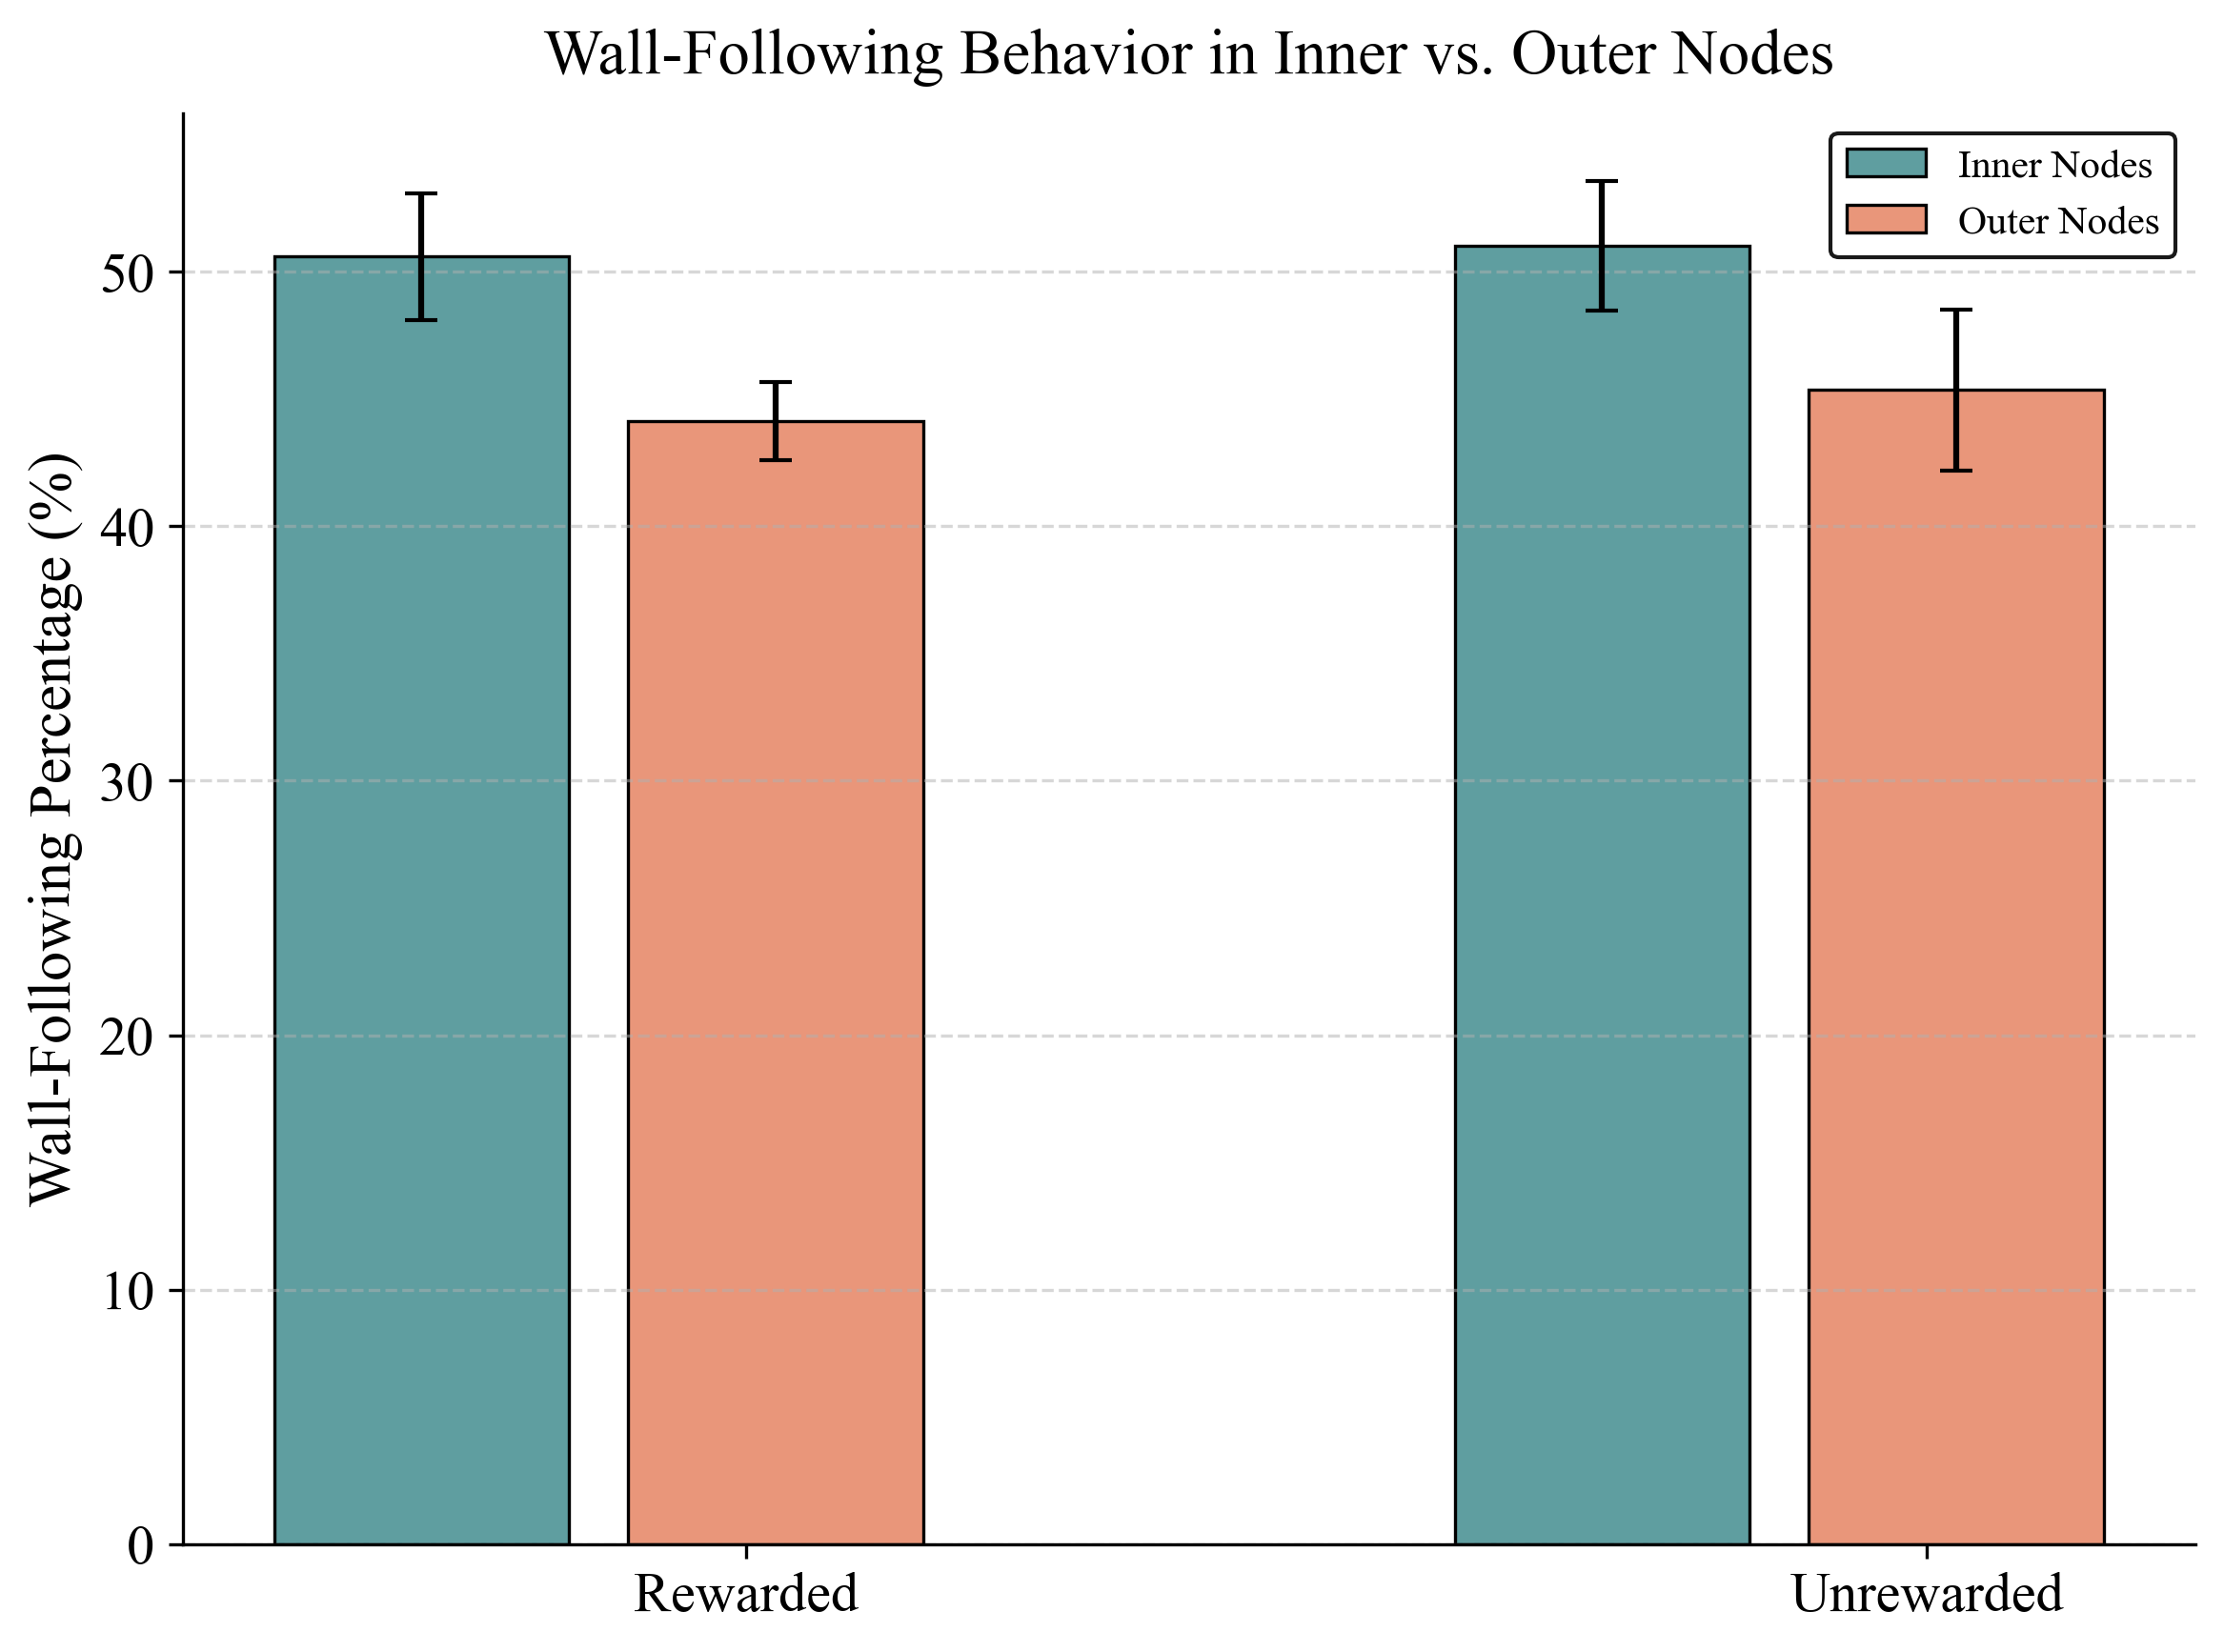

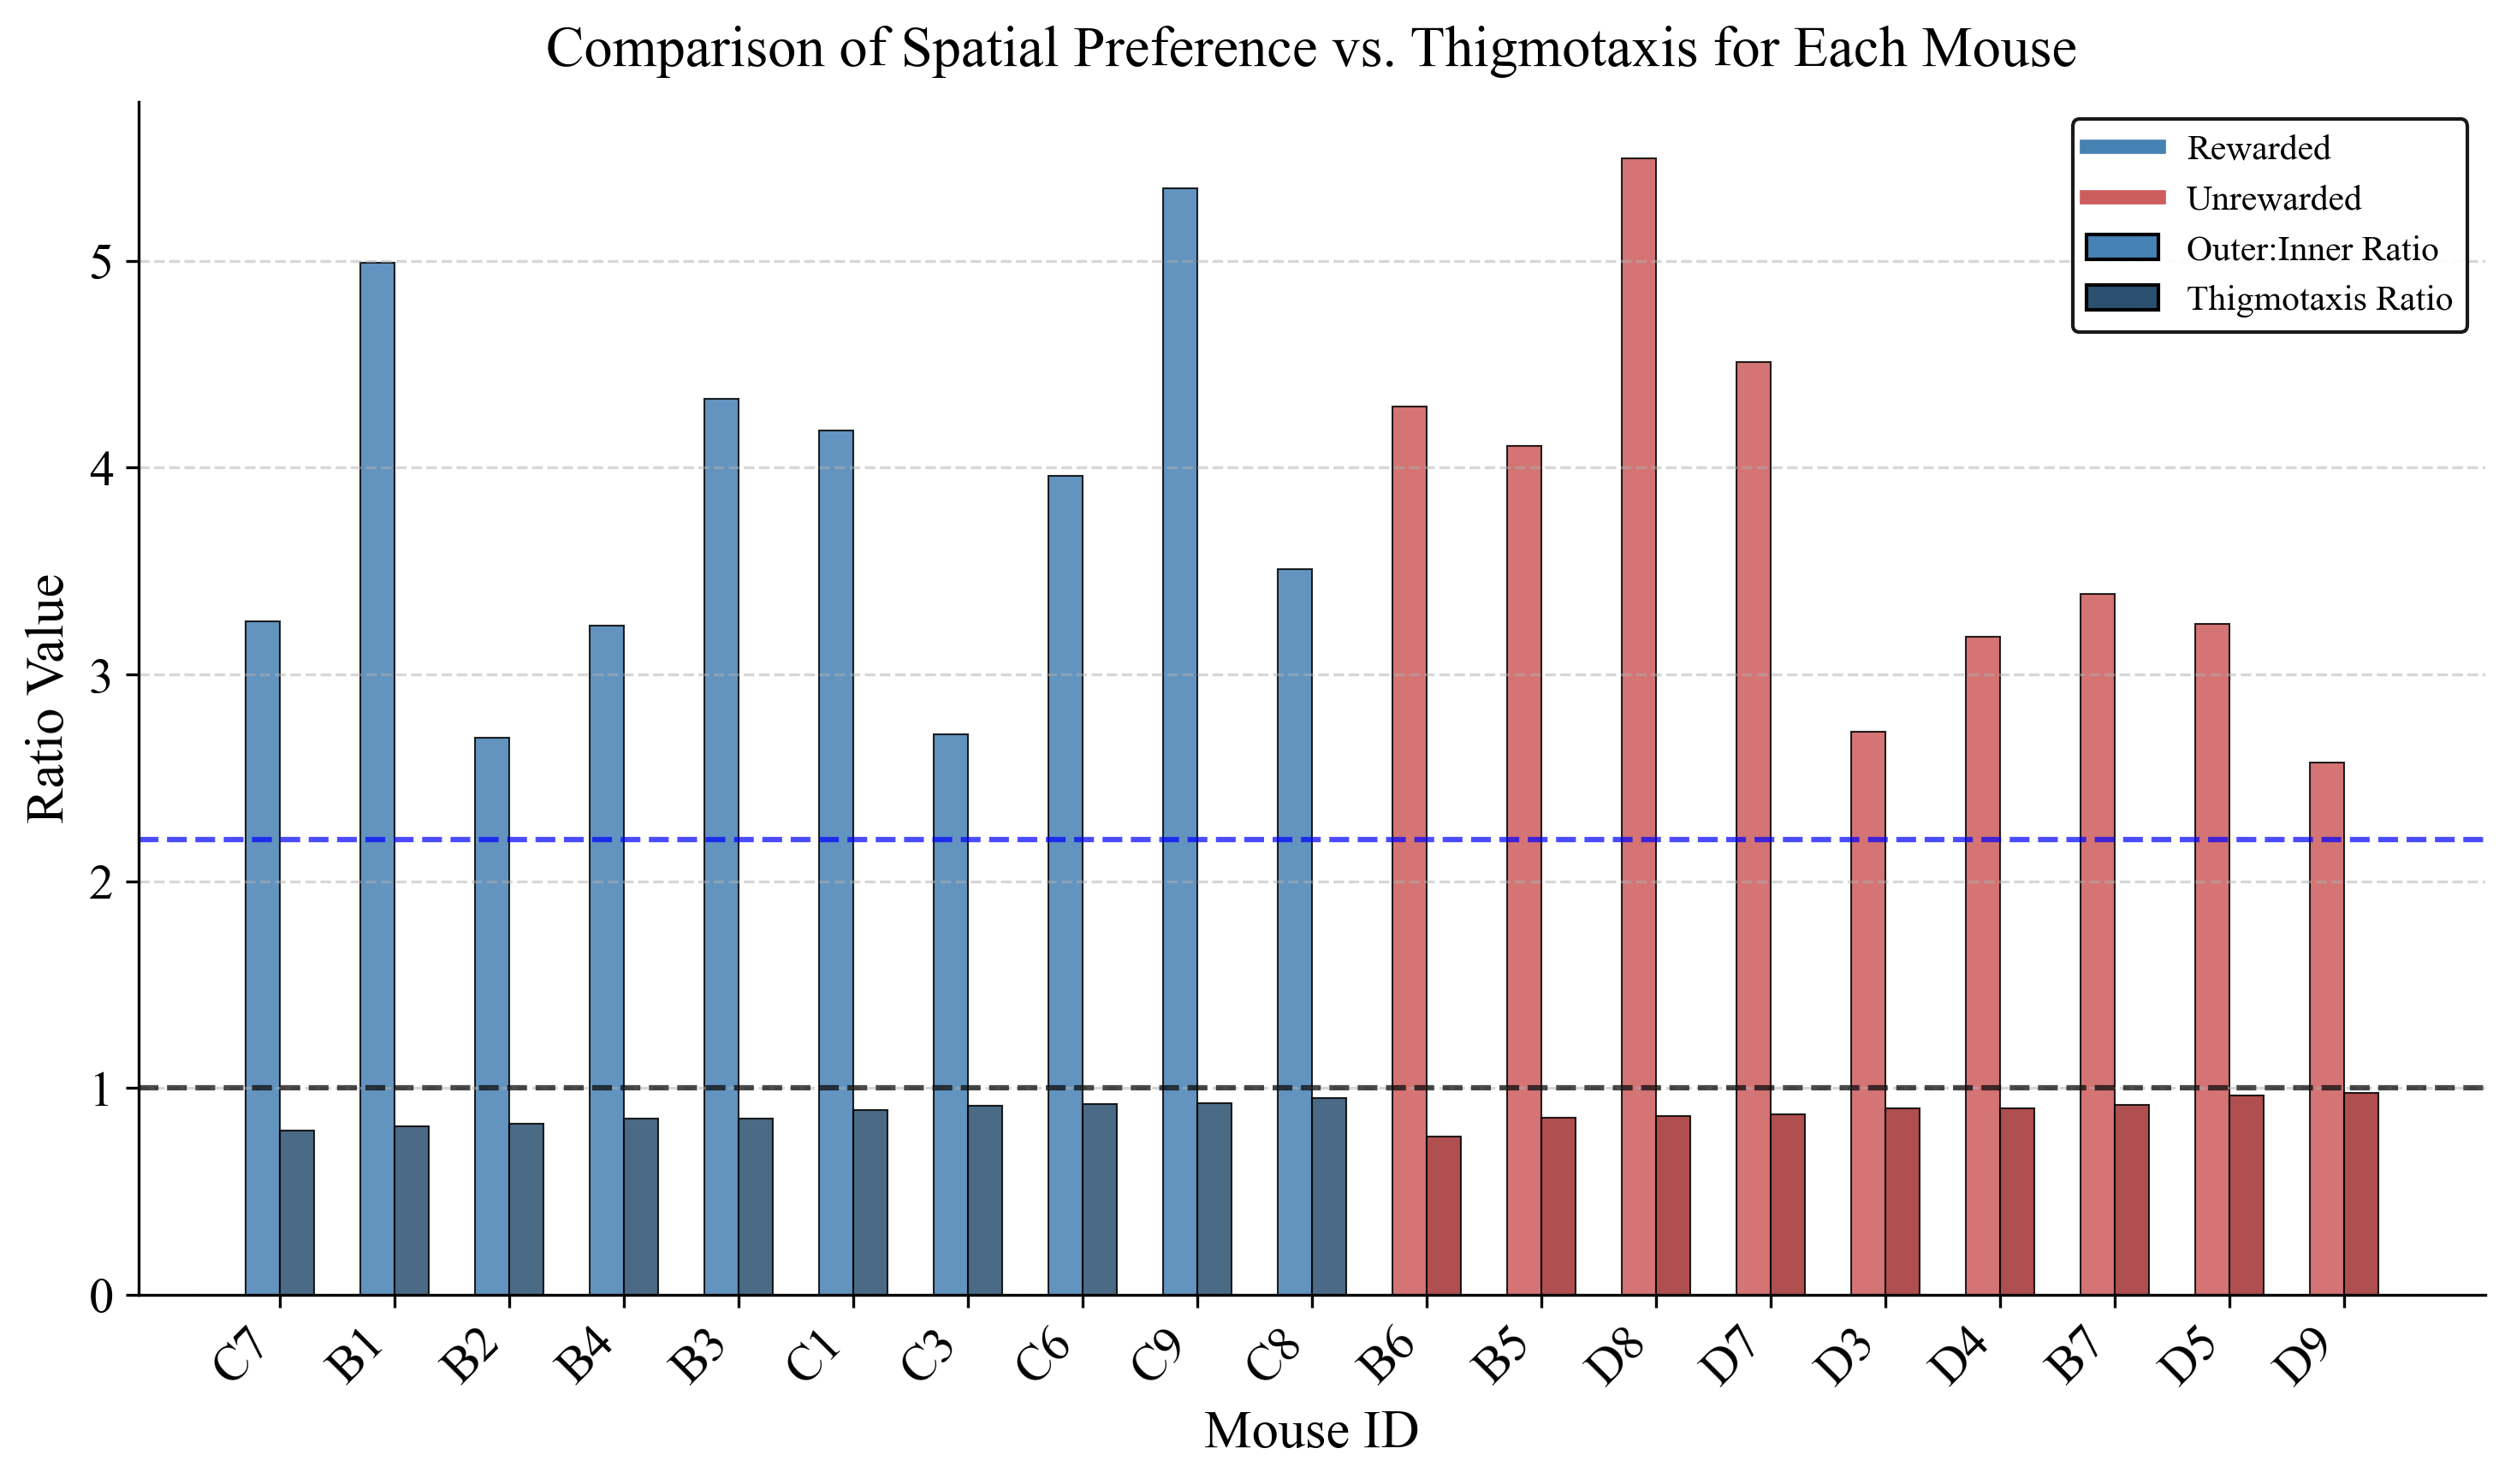

1. wall_following_behavior.pdf
2. spatial_thigmotaxis_comparison.pdf


In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib as mpl

# Font sizes 
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  # base font size
plt.rcParams['axes.titlesize'] = 16  # titles
plt.rcParams['axes.labelsize'] = 15  # axis labels
plt.rcParams['xtick.labelsize'] = 14  # tick labels
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 10  # legend

# Load combined data
with open('all_mice_thigmotaxis.pkl', 'rb') as f:
    all_mice_data = pickle.load(f)

# Separate rewarded and unrewarded mice
rewarded_mice = [m for m in all_mice_data if m['rewarded']]
unrewarded_mice = [m for m in all_mice_data if not m['rewarded']]

# Colours
rewarded_color = '#4682B4'  
unrewarded_color = '#CD5C5C'  
inner_color = '#5F9EA0'  
outer_color = '#E9967A'  
rewarded_color_dark = '#2B5070'  
unrewarded_color_dark = '#A23030'  

# ======= FIGURE 1: Wall-Following Behavior =======
# Create a standalone figure for the wall-following behavior
fig1, ax1 = plt.subplots(figsize=(8, 6), dpi=300)

# Panel A: Thigmotaxis Percentages Comparison with error bars
inner_thigmo_rew = [m['inner_thigmo_pct'] for m in rewarded_mice]
outer_thigmo_rew = [m['outer_thigmo_pct'] for m in rewarded_mice]
inner_thigmo_unrew = [m['inner_thigmo_pct'] for m in unrewarded_mice]
outer_thigmo_unrew = [m['outer_thigmo_pct'] for m in unrewarded_mice]

# Calculate means and standard errors for error bars
inner_means = [np.mean(inner_thigmo_rew), np.mean(inner_thigmo_unrew)]
outer_means = [np.mean(outer_thigmo_rew), np.mean(outer_thigmo_unrew)]

# Standard deviation 
inner_errors = [np.std(inner_thigmo_rew), np.std(inner_thigmo_unrew)]
outer_errors = [np.std(outer_thigmo_rew), np.std(outer_thigmo_unrew)]

bar_width = 0.25  
x = np.arange(2)
group_gap = 0.05  

ax1.bar(x - (bar_width + group_gap/2), inner_means, width=bar_width, yerr=inner_errors, 
       label='Inner Nodes', color=inner_color, capsize=4, edgecolor='black', linewidth=0.8)
ax1.bar(x + (group_gap/2), outer_means, width=bar_width, yerr=outer_errors, 
       label='Outer Nodes', color=outer_color, capsize=4, edgecolor='black', linewidth=0.8)

ax1.set_xticks(x)
ax1.set_xticklabels(['Rewarded', 'Unrewarded'])
ax1.set_ylabel('Wall-Following Percentage (%)')
ax1.set_title('Wall-Following Behavior in Inner vs. Outer Nodes', pad=10)  # Removed the "A:" prefix
ax1.legend(frameon=True, framealpha=0.9, edgecolor='black')
ax1.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adjust layout and save as separate PDF
plt.tight_layout()
plt.savefig('wall_following_behavior.pdf', bbox_inches='tight', format='pdf')
plt.show()


# ======= FIGURE 2: Spatial Preference vs Thigmotaxis =======
# Create a standalone figure for the paired bar chart
fig2, ax2 = plt.subplots(figsize=(10, 6), dpi=300)  # Slightly wider for better readability

# Panel B: Paired Bar Chart showing both ratios for each mouse
sorted_rewarded = sorted([m for m in rewarded_mice if m['thigmotaxis_ratio'] is not None], 
                         key=lambda x: x['thigmotaxis_ratio'])
sorted_unrewarded = sorted([m for m in unrewarded_mice if m['thigmotaxis_ratio'] is not None], 
                           key=lambda x: x['thigmotaxis_ratio'])

# Combine all mice
all_mice = sorted_rewarded + sorted_unrewarded
mouse_ids = [m['mouse_id'] for m in all_mice]
outer_inner_ratios = [m['outer_inner_ratio'] for m in all_mice]
thigmo_ratios = [m['thigmotaxis_ratio'] for m in all_mice]

# Create color arrays for both metrics
colors_outer_inner = [rewarded_color if m['rewarded'] else unrewarded_color for m in all_mice]
colors_thigmo = [rewarded_color_dark if m['rewarded'] else unrewarded_color_dark for m in all_mice]

# Set up positions for paired bars
x = np.arange(len(mouse_ids))
width = 0.3  

rects1 = ax2.bar(x - width/2, outer_inner_ratios, width, label='Outer:Inner Ratio', 
                alpha=0.85, color=colors_outer_inner, edgecolor='black', linewidth=0.5)
rects2 = ax2.bar(x + width/2, thigmo_ratios, width, label='Thigmotaxis Ratio', 
                alpha=0.85, color=colors_thigmo, edgecolor='black', linewidth=0.5)

# Add reference lines
ax2.axhline(y=2.2, color='blue', linestyle='--', alpha=0.7, linewidth=1.5)
ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, linewidth=1.5)

# Add labels 
ax2.set_xlabel('Mouse ID')
ax2.set_xticks(x)
ax2.set_xticklabels(mouse_ids, rotation=45, ha='right')
ax2.set_ylabel('Ratio Value')
ax2.set_title('Comparison of Spatial Preference vs. Thigmotaxis for Each Mouse', pad=10)  # Removed the "B:" prefix

# Legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
    Line2D([0], [0], color=rewarded_color, lw=4, label='Rewarded'),
    Line2D([0], [0], color=unrewarded_color, lw=4, label='Unrewarded'),
    Patch(facecolor=rewarded_color, edgecolor='black', label='Outer:Inner Ratio'),
    Patch(facecolor=rewarded_color_dark, edgecolor='black', label='Thigmotaxis Ratio')
]
ax2.legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.9, 
          edgecolor='black')

ax2.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Adjust layout and save as separate PDF
plt.tight_layout()
plt.savefig('spatial_thigmotaxis_comparison.pdf', bbox_inches='tight', format='pdf')
plt.show()


print("1. wall_following_behavior.pdf")
print("2. spatial_thigmotaxis_comparison.pdf")